## 3. Epoching and Averaging (Evoked Responses)

**Learning Goals**:

- Extract events from stimulus channels
- Define epochs (time-locked data segments around events)
- Apply baseline correction
- Average across epochs to create evoked responses
- Visualize evoked data and topographic maps (static)

### Set up

In [1]:
import mne
import matplotlib.pyplot as plt
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib', set_env=True)

Using matplotlib as 2D backend.


In [2]:
data_path = mne.datasets.sample.data_path()
raw_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)

raw.info['bads'] = ['EEG 017', 'EEG 024', 'EEG 026', 'EEG 035', 
                    'EEG 036', 'EEG 042', 'EEG 043', 'EEG 052', 
                    'EEG 056', 'EEG 060', 'EEG 003', 'EEG 007',
                    'EEG 010', 'EEG 001', 'EEG 002', 'EEG 008',
                    'EEG 004', 'EEG 006', 'EEG 005', 'EEG 015',
                    'EEG 010']

raw.pick_types(meg=False, eeg=True, eog=True, stim=True)

print(raw.info)

Opening raw data file /Users/yibeisita/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<Info | 19 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 Stimulus, 40 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172

### Extract and Inspect Events

Finding events on: STI 014
320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Unique event IDs found: {np.int64(32), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}


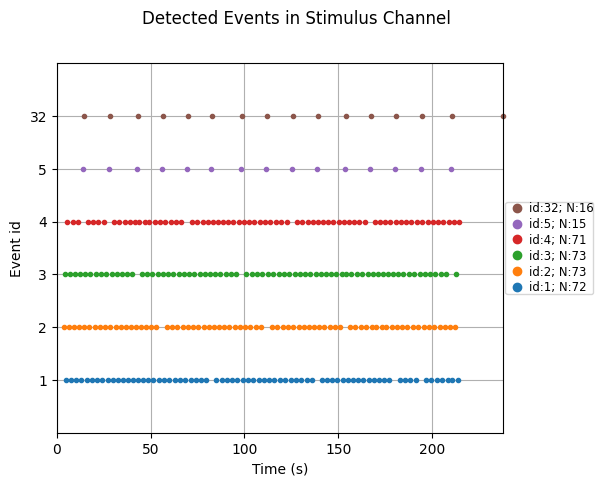

In [3]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=True)

# Inspect event codes
unique_events = set(events[:, 2])
print("Unique event IDs found:", unique_events)

# Plot events timeline
fig = mne.viz.plot_events(
    events,
    sfreq=raw.info['sfreq'],
    first_samp=raw.first_samp,
    show=False
)
fig.suptitle("Detected Events in Stimulus Channel")
plt.show()

### Define Event IDs and Epoch Parameters
An epoch = a short time window of EEG data time-locked to a stimulus.

In [4]:
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2,
            'Visual/Left': 3, 'Visual/Right': 4}

# Define epoch time window (e.g., -200ms to 500ms)
tmin, tmax = -0.2, 0.5  # seconds

epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
                    picks='eeg', baseline=(None, 0),
                    preload=True, reject_by_annotation=True)
print(epochs)


Not setting metadata
289 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 289 events and 421 original time points ...
0 bad epochs dropped
<Epochs | 289 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~40.1 MiB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73
 'Visual/Left': 73
 'Visual/Right': 71>


### Inspect Epochs 

Epoch counts by event type:
{'Auditory/Left': 1, 'Auditory/Right': 2, 'Visual/Left': 3, 'Visual/Right': 4}


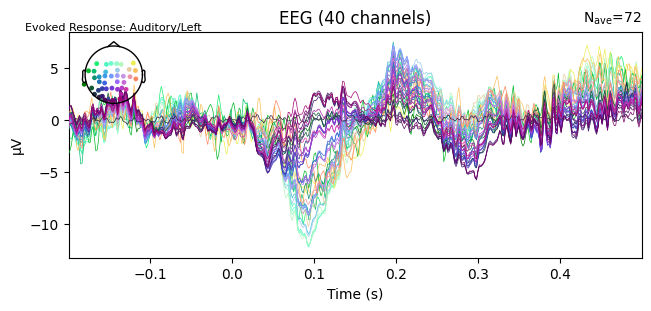

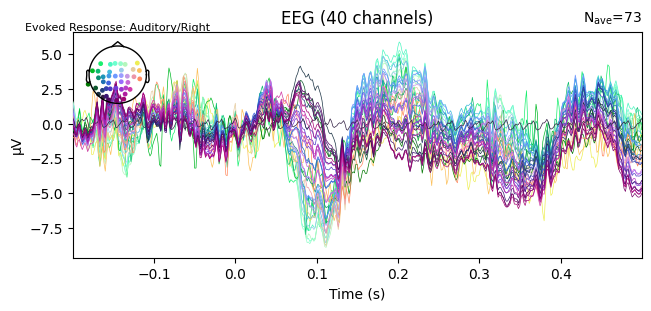

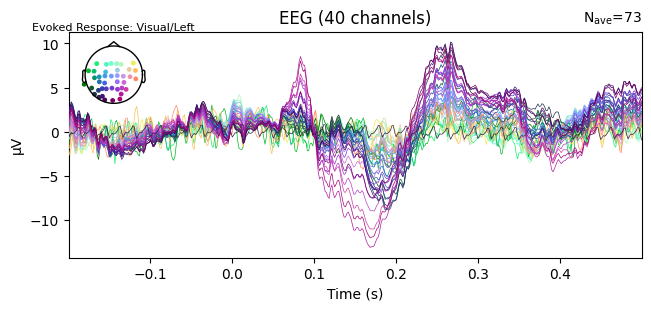

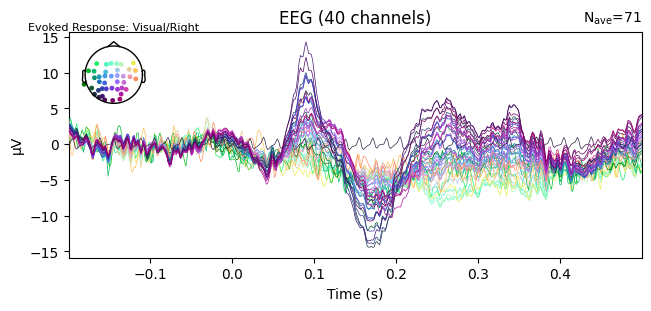

In [5]:
print("Epoch counts by event type:")
print(epochs.event_id)

# Visualize the first few averaged epochs (static)
evoked_dict = {cond: epochs[cond].average() for cond in event_id}
for cond, evoked in evoked_dict.items():
    fig = evoked.plot(spatial_colors=True, show=False)
    plt.title(f"Evoked Response: {cond}", fontsize=8)
    plt.show()
    fig.savefig(f"../results/evoked_{cond.split('/')[0].lower()}_{cond.split('/')[1].lower()}.png", dpi=150)

### Compare Conditions (Evoked Overlays)
- The evoked response (also called ERP or ERF) is the average EEG signal time-locked to a specific event type.
- Averaging reduces noise and reveals the brain’s consistent response to a stimulus.

combining channels using "mean"
combining channels using "mean"


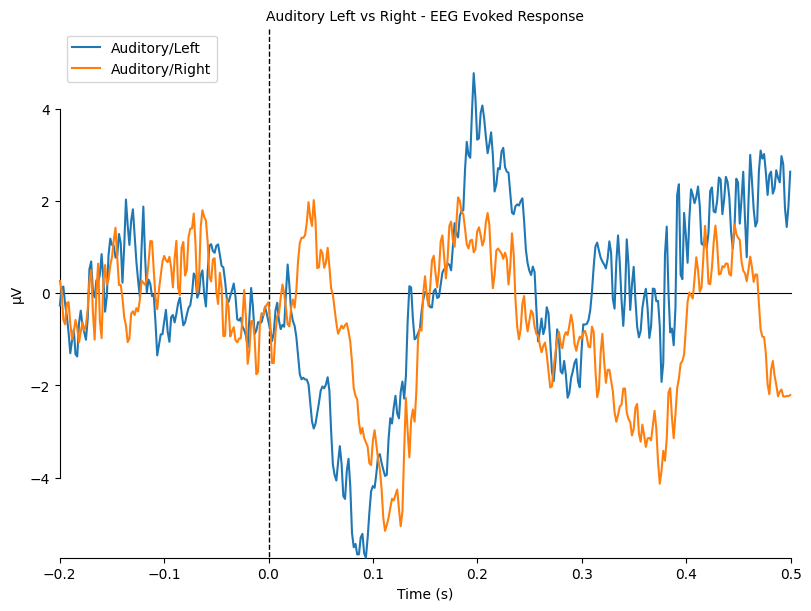

In [7]:
fig = mne.viz.plot_compare_evokeds(
    {'Auditory/Left': evoked_dict['Auditory/Left'],
     'Auditory/Right': evoked_dict['Auditory/Right']},
    picks='eeg', combine='mean', show=False
)
plt.title("Auditory Left vs Right - EEG Evoked Response", fontsize=10)
plt.show()
fig[0].savefig("../results/evoked_comparison_auditory.png", dpi=150, bbox_inches="tight")

combining channels using "mean"
combining channels using "mean"


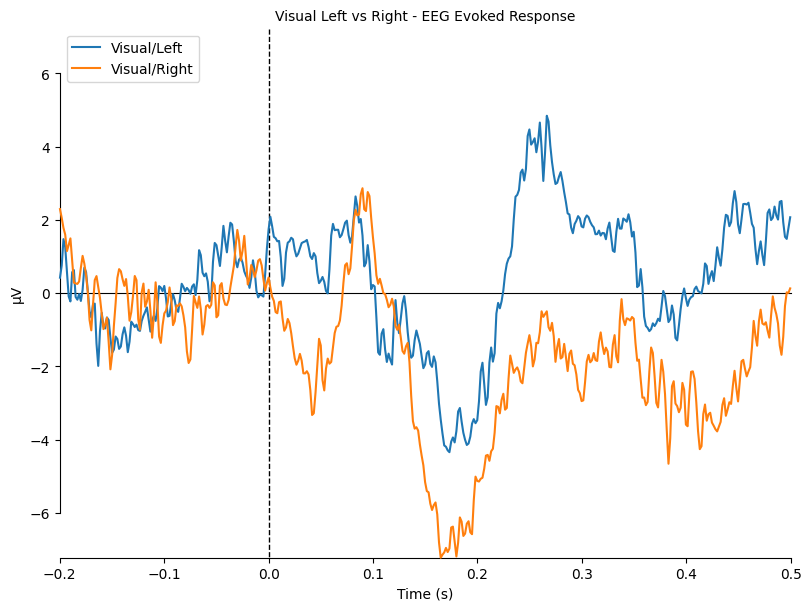

In [8]:
fig = mne.viz.plot_compare_evokeds(
    {'Visual/Left': evoked_dict['Visual/Left'],
     'Visual/Right': evoked_dict['Visual/Right']},
    picks='eeg', combine='mean', show=False
)
plt.title("Visual Left vs Right - EEG Evoked Response", fontsize=10)
plt.show()
fig[0].savefig("../results/evoked_comparison_visual.png", dpi=150, bbox_inches="tight")

### Topograpgic Map of Evoked Response
- A topomap shows brain activity across the scalp surface at a given moment in time.
- Each point = an EEG electrode.
- Colors represent voltage differences (e.g., red = positive, blue = negative).
- Useful for visualizing where in the brain signals are strongest.

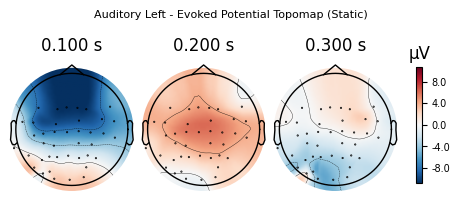

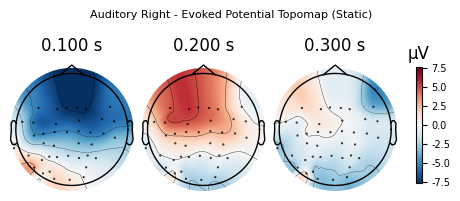

In [9]:
# Plot topomap of evoked potentials (at 100ms)
fig = evoked_dict['Auditory/Left'].plot_topomap(times=[0.1, 0.2, 0.3], show=False)
plt.suptitle("Auditory Left - Evoked Potential Topomap (Static)", fontsize=8)
plt.show()
fig.savefig("../results/topomap_auditory_left.png", dpi=150, bbox_inches="tight")

fig = evoked_dict['Auditory/Right'].plot_topomap(times=[0.1, 0.2, 0.3], show=False)
plt.suptitle("Auditory Right - Evoked Potential Topomap (Static)", fontsize=8)
plt.show()
fig.savefig("../results/topomap_auditory_right.png", dpi=150, bbox_inches="tight")

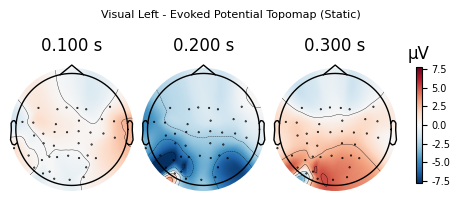

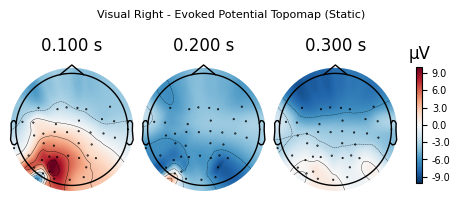

In [10]:
# Plot topomap of evoked potentials (at 100ms)
fig = evoked_dict['Visual/Left'].plot_topomap(times=[0.1, 0.2, 0.3], show=False)
plt.suptitle("Visual Left - Evoked Potential Topomap (Static)", fontsize=8)
plt.show()
fig.savefig("../results/topomap_visual_left.png", dpi=150, bbox_inches="tight")

fig = evoked_dict['Visual/Right'].plot_topomap(times=[0.1, 0.2, 0.3], show=False)
plt.suptitle("Visual Right - Evoked Potential Topomap (Static)", fontsize=8)
plt.show()
fig.savefig("../results/topomap_visual_right.png", dpi=150, bbox_inches="tight")
